In [40]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import math
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from h3 import h3
from keplergl import KeplerGl 
%matplotlib inline
sns.set_style('darkgrid')
plt.rc('font', family='Karla')

# Table of contents
1. [Introduction](#introduction)
2. [Trip Duration](#tripduration)
3. [Another paragraph](#paragraph2)
4. [Another paragraph](#paragraph2)
5. [Another paragraph](#paragraph2)
6. [Another paragraph](#paragraph2)

In [41]:
data = pd.read_csv('trips.csv')

In [42]:
# times to datetime
data[['start_time','end_time']] = data[['start_time','end_time']].applymap(lambda x: pd.to_datetime(x))

### 1. Trips by Day and Time

In [43]:
# numeric day of week
data['start_day'] = data.start_time.dt.dayofweek
# day of week name
data['start_day_name'] = data.start_time.dt.day_name()
# start hour
data['start_hour'] = data.start_time.dt.hour

In [44]:
# change int to category
data['start_day'] = data.start_day.astype('category')
data['start_hour'] = data.start_hour.astype('category')

In [45]:
# generate 3-hr periods
data['start_hour_period'] = data.start_hour.apply(lambda x: math.floor(x/3))
data['start_hour_period'] = data.start_hour_period.astype('category')

#### Trips by day of week

In [46]:
data['start_day_name'].value_counts()

Saturday     12397
Sunday       11433
Friday       10204
Monday        9420
Tuesday       9286
Thursday      8923
Wednesday     8337
Name: start_day_name, dtype: int64

#### Trips by time of day

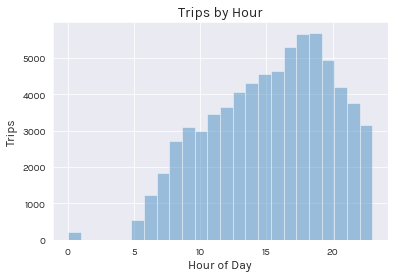

In [47]:
ax = sns.distplot(data['start_hour'], bins=24, kde=False)
ax.set_ylabel('Trips', fontsize=12)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title('Trips by Hour', fontsize=14)
plt.show()

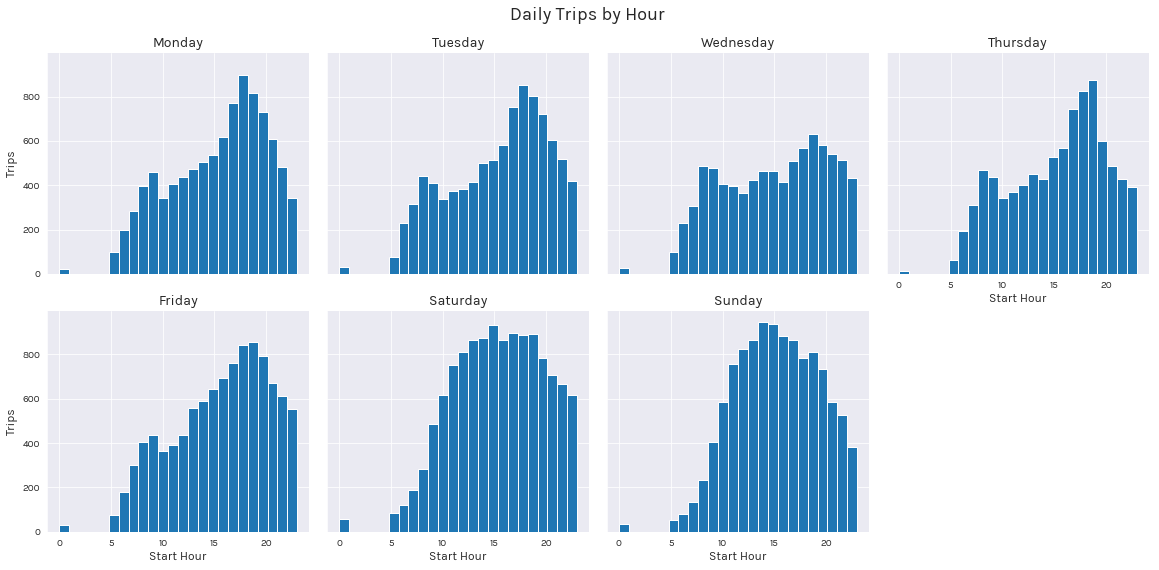

In [48]:
g = sns.FacetGrid(data, col='start_day_name', col_wrap=4, height=4)
g = g.map(plt.hist, 'start_hour', bins=24)
g.set_titles("{col_name}", size=14)
g.set_ylabels('Trips', fontsize=12)
g.set_xlabels('Start Hour', fontsize=12)
g.fig.suptitle('Daily Trips by Hour', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

Weekdays show a bit of a spike during morning commute hours, while ridership is a bit higher overall on weekends. Ridership skews toward the afternoon across the board.

### 2. Trip Duration <a name="tripduration"></a>

In [49]:
# get duration in minutes
data['trip_duration_minutes'] = (data.end_time - data.start_time).apply(lambda x: math.floor(x.seconds/60))

In [50]:
print("Trip Duration Basic Stats")
data.trip_duration_minutes.describe()

Trip Duration Basic Stats


count    70000.000000
mean        36.642286
std         27.055392
min          0.000000
25%         18.000000
50%         31.000000
75%         49.000000
max        951.000000
Name: trip_duration_minutes, dtype: float64

#### Overall Distribution of Trip Duration

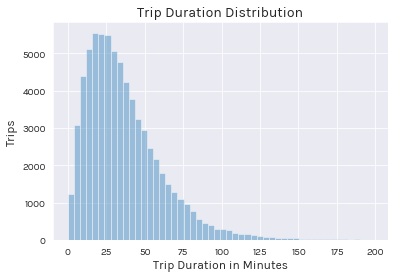

In [51]:
sns.distplot(data[data.trip_duration_minutes < 200]['trip_duration_minutes'], bins=50, kde=False)
plt.ylabel('Trips', fontsize=12)
plt.xlabel('Trip Duration in Minutes', fontsize=12)
plt.title('Trip Duration Distribution', fontsize=14)
plt.show()

#### Trip duration by period of the day

In [52]:
td_mean = data.trip_duration_minutes.mean()
td_std = data.trip_duration_minutes.std()

# set the upper bound for the plots at 2 std above the mean
td_upper = td_mean + 2*td_std

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


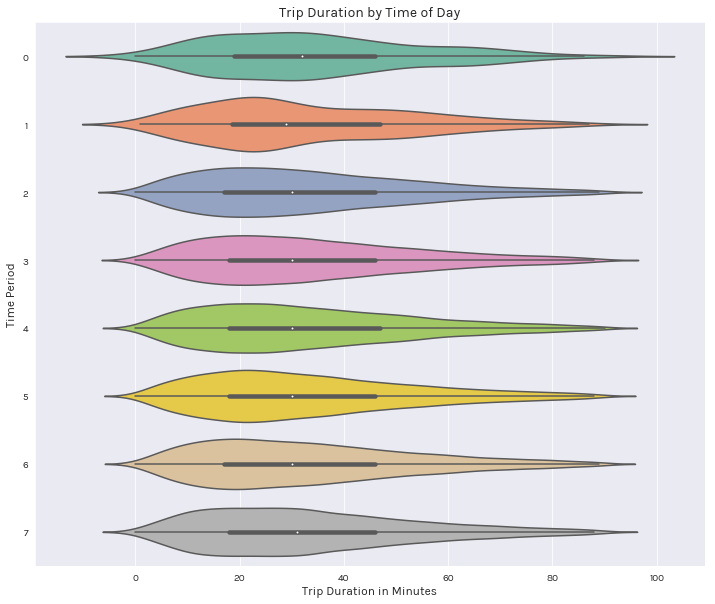

In [53]:
d = data[data.trip_duration_minutes < td_upper]
plt.figure(figsize=(12,10))
sns.violinplot(x='trip_duration_minutes', y='start_hour_period', data=d, orient='h', palette="Set2")
plt.ylabel('Time Period', fontsize=12)
plt.xlabel('Trip Duration in Minutes', fontsize=12)
plt.title('Trip Duration by Time of Day', fontsize=14)
plt.show()

Not too much variation here...

#### Trip duration by day of week

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


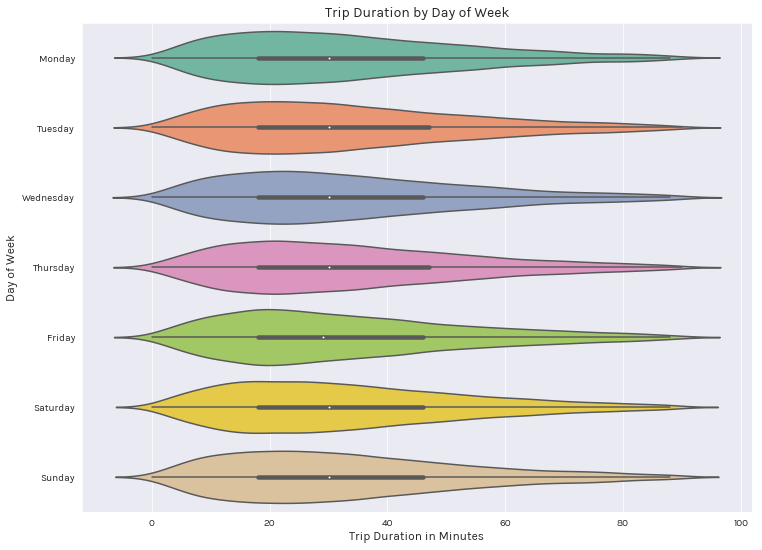

In [54]:
d = data[data.trip_duration_minutes < td_upper]
plt.figure(figsize=(12,9))
sns.violinplot(x='trip_duration_minutes', y='start_day_name', data=d, orient='h', palette="Set2")
plt.ylabel('Day of Week', fontsize=12)
plt.xlabel('Trip Duration in Minutes', fontsize=12)
plt.title('Trip Duration by Day of Week', fontsize=14)
plt.show()

Nothing significant here either.

### 3. Trips by Vehicle ID

In [55]:
len(data.vehicle_id.unique())

1000

#### Average rides per vehicle per day

In [56]:
data.groupby(['start_day','start_day_name','vehicle_id']).trip_id.count() \
    .groupby(['start_day','start_day_name']).mean().to_frame('avg_rides_per_vehicle') \
    .reset_index()[['start_day_name','avg_rides_per_vehicle']]

,start_day_name,avg_rides_per_vehicle
0,Monday,9.420000
1,Tuesday,9.286000
2,Wednesday,8.345345
3,Thursday,8.923000
4,Friday,10.204000
5,Saturday,12.397000
6,Sunday,11.433000


Weekends see slightly higher numbers of rides per vehicle.

#### Vehicles with the most trips overall

In [57]:
trips_by_vehicle = data.groupby('vehicle_id').size().to_frame('trips') \
                        .sort_values(by='trips', ascending=False).reset_index()

In [58]:
trips_by_vehicle.head()

,vehicle_id,trips
0,298,98
1,12,98
2,924,97
3,947,94
4,322,93


#### Vehicles with the least trips overall

In [59]:
trips_by_vehicle.tail()

,vehicle_id,trips
995,902,49
996,133,48
997,558,48
998,592,48
999,251,46


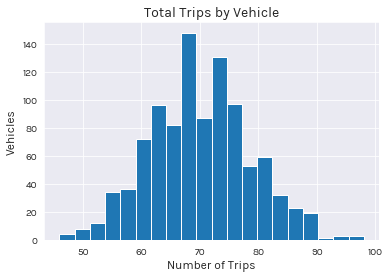

In [60]:
# distribution of trips by vehicle for the week
plt.hist(trips_by_vehicle.trips, bins=20)
plt.title('Total Trips by Vehicle', fontsize=14)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Vehicles', fontsize=12)
plt.show()

The average number of trips per vehicle for the week is 70.

### 4. Most Active Users

In [61]:
trips_by_user = data.groupby('user_id').size().to_frame('trips') \
                    .sort_values(by='trips', ascending=False).reset_index()

In [62]:
trips_by_user.head(10)

,user_id,trips
0,7882,12
1,803,12
2,4571,12
3,13209,12
4,15242,12
5,13870,12
6,14905,11
7,7448,11
8,10213,11
9,17595,11


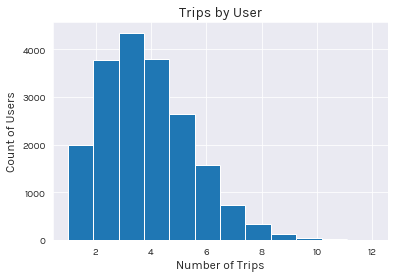

In [63]:
plt.hist(trips_by_user.trips, bins=12)
plt.title('Trips by User', fontsize=14)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Count of Users', fontsize=12)
plt.show()

In [64]:
trips_by_user.trips.describe()

count    19389.000000
mean         3.610294
std          1.776816
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         12.000000
Name: trips, dtype: float64

### 5. Demand by Time and Location (Geovisualization)

In [65]:
# create shapely geom and geodataframes
start_geom = [Point(x,y) for x,y in zip(data.start_lon, data.start_lat)]
start_gdf = gpd.GeoDataFrame(data, crs={'init': 'epsg:4326'}, geometry=start_geom).to_crs(epsg=3857)

end_geom = [Point(x,y) for x,y in zip(data.end_lon, data.end_lat)]
end_gdf = gpd.GeoDataFrame(data, crs={'init': 'epsg:4326'}, geometry=end_geom).to_crs(epsg=3857)

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


#### Start Location H3 Cells
The `h3_level` variable can be changed to use a different H3 'zoom level' throughout. Using level 9 here.

In [66]:
start_hex = []
end_hex = []
h3_level = 9

# map coordinates to h3 ids
for i,row in data.iterrows():
    start_hex.append(h3.geo_to_h3(row.start_lat, row.start_lon, h3_level))
    end_hex.append(h3.geo_to_h3(row.end_lat, row.end_lon, h3_level))

In [67]:
data[f'start_hexid_{h3_level}'] = start_hex
data[f'end_hexid_{h3_level}'] = end_hex

# get counts of trip starts and ends by h3 cell
data_start_agg = data.groupby(f'start_hexid_{h3_level}').size().to_frame('cnt').reset_index()
data_end_agg = data.groupby(f'end_hexid_{h3_level}').size().to_frame('cnt').reset_index()

In [68]:
# find center of hex for visualization
def get_hex_center(df, hex_col):
    df['lat'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    df['lng'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    df_geom = [Point(x,y) for x,y in zip(df.lng, df.lat)]
    return gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, \
                                     geometry = df_geom).to_crs(epsg=3857) 

# map viz function
def plot_map(gdf, vmin, vmax, metric_col='cnt', ax=ax, marker='o', alpha=1, colormap='viridis', s=20, legend=True):    
    gdf.plot(metric_col, ax=ax, edgecolors='none', cmap=colormap, marker=marker, 
                alpha=alpha, s=s, legend=legend, vmin=vmin, vmax=vmax, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    ax.set_axis_off()
    ctx.add_basemap(ax, url=ctx.providers.CartoDB.Positron)

In [69]:
start_agg_gdf = get_hex_center(data_start_agg, f'start_hexid_{h3_level}')
end_agg_gdf = get_hex_center(data_end_agg, f'end_hexid_{h3_level}')

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


#### Kepler GL Viz
### See the Kepler map [here](https://iwsstuart.github.io/trips_eda/kepler_viz.html).
#### Map has a layer for each day of the week. Use the controls on the left slide-out panel to toggle layers.

In [70]:
start_agg_day = data.groupby([f'start_hexid_{h3_level}','start_day_name']).size().to_frame('cnt').reset_index()
start_agg_day = get_hex_center(start_agg_day, f'start_hexid_{h3_level}')

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [71]:
start_agg_kepler = start_agg_day.rename(columns={f'start_hexid_{h3_level}':'hex_id','cnt':'trip_starts'})

In [72]:
# convert back to dataframe and remove geom column
start_agg_kepler = pd.DataFrame(start_agg_kepler.iloc[:,:-3])

In [73]:
# load the config
%run kepler_config.py

<Figure size 432x288 with 0 Axes>

In [74]:
map = KeplerGl(config=config, height=500)
for day in start_agg_kepler.start_day_name.unique():
    d = start_agg_kepler[start_agg_kepler.start_day_name == day]
    map.add_data(d, name=day)
map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qf8x8ao', 'type': …

In [75]:
map.save_to_html(file_name='docs/kepler_viz.html')

Map saved to docs/kepler_viz.html!


#### Overall Demand

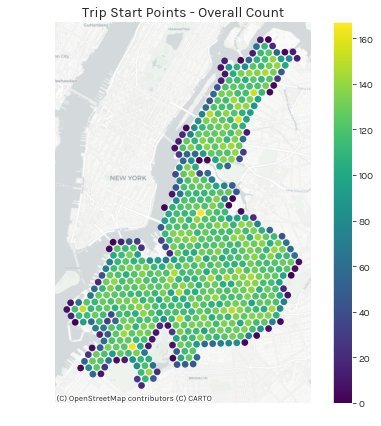

In [76]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plot_map(start_agg_gdf, 0, start_agg_gdf.cnt.max(), ax=ax, s=45)
ax.set_title('Trip Start Points - Overall Count', fontsize=14)
plt.show()

Low counts around the edges are due to the entire H3 cell not being within the service area.

#### Trip Start Locations by Time of Day

In [77]:
# add time of day to start location data and plot
start_agg_period = data.groupby([f'start_hexid_{h3_level}','start_hour_period']).size().to_frame('cnt').reset_index()
start_agg_period = get_hex_center(start_agg_period, f'start_hexid_{h3_level}')

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


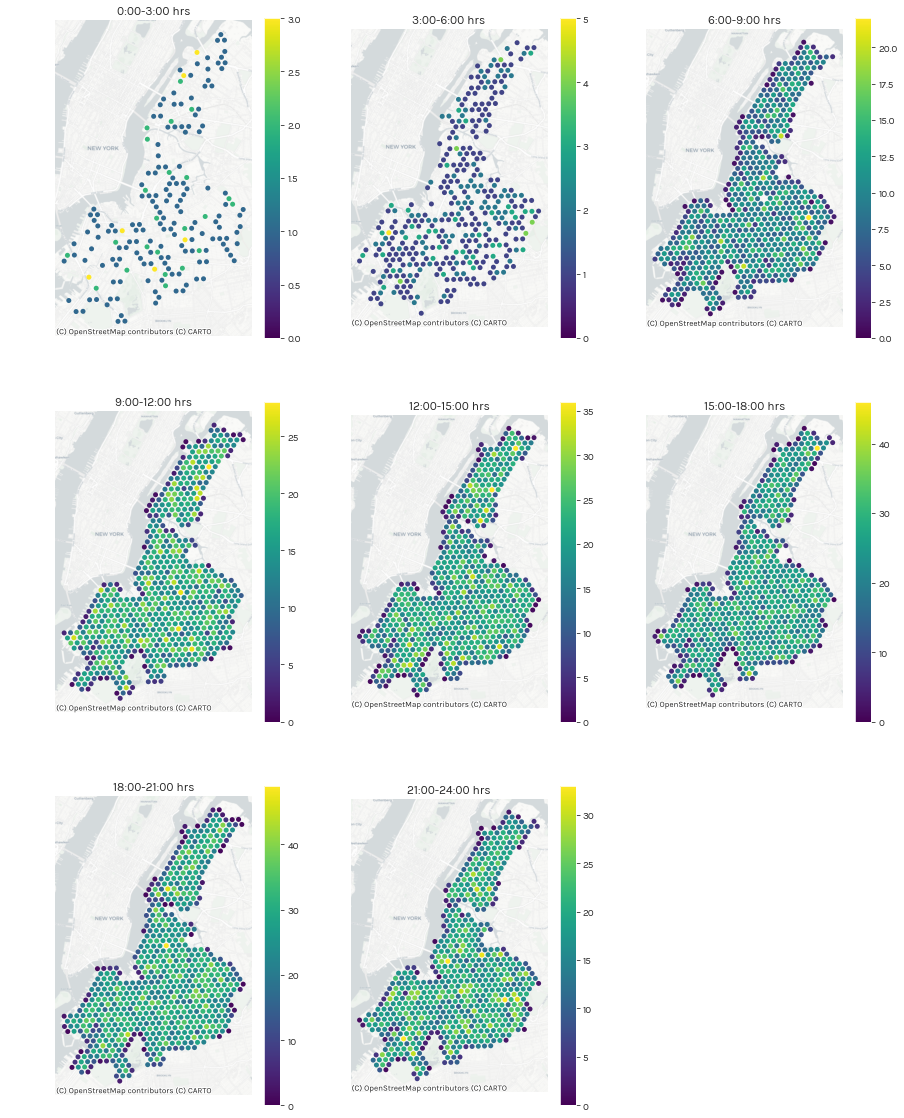

In [78]:
fig = plt.figure(figsize=(15,20))
for period in list(range(0,8)):
    d = start_agg_period[start_agg_period.start_hour_period == period]
    ax = fig.add_subplot(3, 3, period + 1)
    plot_map(d, 0, d.cnt.max(), ax=ax, s=25)
    ax.set_title(f'{period*3}:00-{period*3+3}:00 hrs')

Comparing across time of day and using different color scales to make the hotspots visible for each time period, we can see that the patterns in the hotspots change. For example, between 9 and 12am, hotspots appear smaller and more evenly distributed than between 9pm and 12am. Overall ridership follows the same pattern as the _daily trips by hour_ plots above.

#### Trip Start Locations by Day of Week

In [79]:
# add period of day to start location data and plot
start_agg_day = data.groupby([f'start_hexid_{h3_level}','start_day','start_day_name']) \
    .size().to_frame('cnt').reset_index()
start_agg_day = get_hex_center(start_agg_day, f'start_hexid_{h3_level}')

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


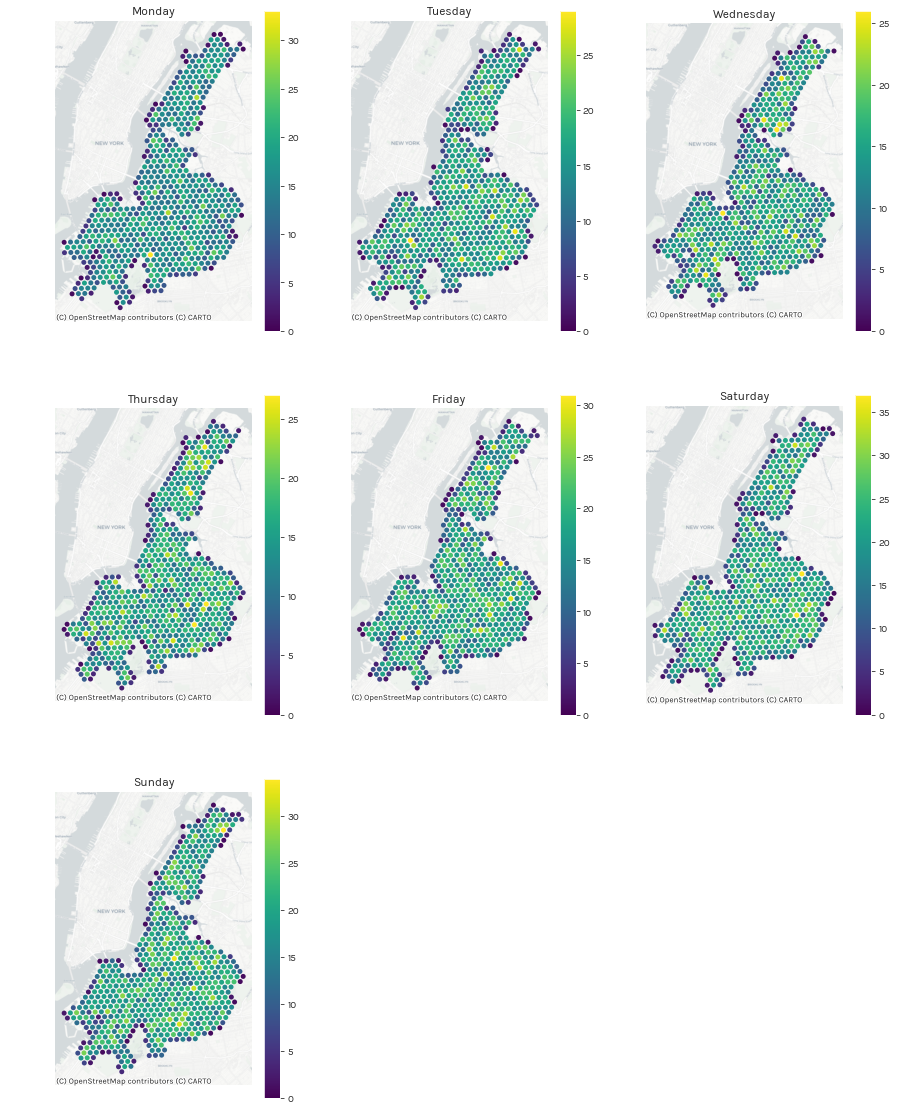

In [80]:
fig = plt.figure(figsize=(15,20))
for day in list(range(0,7)):
    d = start_agg_day[start_agg_day.start_day == day]
    ax = fig.add_subplot(3, 3, day + 1)
    plot_map(d, 0, d.cnt.max(), ax=ax, s=25)
    ax.set_title(f'{d.start_day_name.values[0]}')

Likewise, comparing across days of the week, there are some differences. Thursday has high demand in Queens relative to the rest of the service area. This could be an anomaly or something to watch out for on subsequent Thursdays.

#### Trip Durations by Start Location

In [81]:
data_start_dur = data[[f'start_hexid_{h3_level}','trip_duration_minutes']] \
                    .groupby(f'start_hexid_{h3_level}').mean().reset_index() \
                    .rename(columns={'trip_duration_minutes':'trip_dur_avg'})

In [82]:
start_dur_gdf = get_hex_center(data_start_dur, f'start_hexid_{h3_level}')

/Users/ian.stuart/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


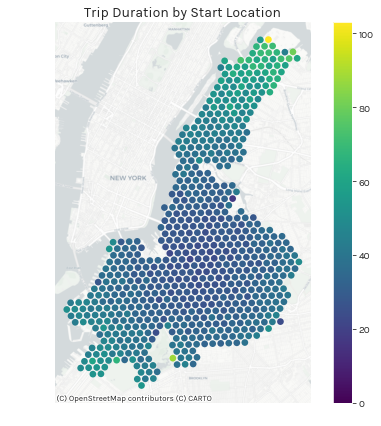

In [83]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plot_map(start_dur_gdf, 0, start_dur_gdf.trip_dur_avg.max(), metric_col='trip_dur_avg', ax=ax, s=45)
ax.set_title('Trip Duration by Start Location', fontsize=14)
plt.show()

Trip durations vary very little by start location. The far southern and northern areas of the service area show slightly longer average trip times - which makes sense due to geography.

### 6. User Segmentation

There are many possible dimensions on which to segment users or customers, and the applications or benefits of segmentation can vary depending on the dimensions that are chosen. Given the prompt, I'm focusing primarily on behavioral (and geographic?) segmentation - classifying users based on how they use the service - rather than other dimensions related to demographics or psychographics. The latter can be useful for understanding who your users are and how target them and meet their specific needs, but for initial questions around quality of service and efficiency of operations, the behavioral dimensions seem most relevant.

### Dimensions of Segmentation
Note: I've defined these as binary classifications, but in reality they may be multi-class.

#### 1st Dimension: Commute vs Leisure Rider

Some Revel riders may take two trips almost every weekday, with the start and end points matching up with where they live and where we might assume that they work. Their trips also may not come during traditional commute times, but they might be very consistent in terms of location and daily or weekly timing. These riders can be classified as **commute** riders. 

Other riders will commonly take trips in the evening or on weekends, at varying hours and between varying locations. These two types of riders have very different behaviors, but both can be used to better understand and serve Revel users. These are **leisure** riders.

**Segmentation defined based on:**
- Weekday vs weekend ridership
- Consistency of start and end locations
- Consistency of start and end times

**Potential impacts on service:**
- Hotspots of commute riders (both "home" and "work" locations) will have more predictable demand. The timing and location of rebalancing and battery replacement can be informed by these user types - patterns may emerge even among leisure riders.
- Understanding where alternate forms of transit are lacking and where Revel can gain a strong position as a transit option.
- Identifying the kinds of areas where Revel commuting is a viable option.

#### 2nd Dimension: Frequent vs Occasional Rider

Even if two areas see the same number of trips, the frequency with which riders use the service may vary between them. An area with higher population density may have many riders that use Revel infrequently, while an area with lower density may have few riders who use it frequently. The overall demand is similar, but there still may be differences in how best to serve these areas.

**Defined based on:**
- Trip frequency, e.g. trips per week

**Potential impacts on service:**
- Frequent riders may have less tolerance for walking long distance to find a scooter. It may be more important to maintain a certain quantity and density of supply in areas with many frequent riders, even if overall trip levels are the same.

Fair weather vs die hard.

#### 3rd Dimension: Practical vs User Experience Rider

Some riders may be using Revel because the alternatives are limited or inferior (inefficient, more expensive, etc.). They may live far from viable public transit options and have decided to use Revel as a last mile solution; there may be limited bus service for their common travel routes or times. Revel is by far the best, or possibly the only, transit option for their needs. They choose Revel because it is simply the most **practical**.

Other riders live on top of a subway station, but they decide to use Revel anyway because they find it more pleasant or more fun. They choose Revel because of the **user experience**.

Knowing where a rider lives, and where they commonly travel to, can help determine which type of rider they are. Public transit route and stop data, as well as prior studies, can help determine if a rider lives in a transit desert (though this is less common in the current NYC service area). If their area is transit poor, Revel may be providing and indispensable service.

**Defined based on:**
- Distance from start location to nearest subway station (bus stops could be used as a secondary transit option).

**Potential impacts on service:**
- There may be untapped demand in areas where other transit is lacking. Experiments could be run to see if an increase in supply is absorbed.

**Third-party data needed:**
- Public transit stops

#### Overall Segmentation Results

dfsd

In [599]:
# dimension combinations...

In [734]:
# when, where, how many... + the who (user segmentation)